<a href="https://colab.research.google.com/github/Abdallhss/Reinformcent-Learning-USM/blob/main/ActorCritic_Current%26Temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
from keras import backend as K
from keras.layers import Dense, Activation, Input
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from collections import deque


%matplotlib inline

import numpy as np

In [183]:
# get the current response given the frequency
class USM_model:
  def __init__(self, opt_freq, min_current, init_freq, min_temp, max_temp, step_size):
    self.opt_freq = opt_freq
    self.min_current = min_current
    self.freq = init_freq
    self.min_temp = min_temp
    self.max_temp = max_temp
    self.temp = min_temp
    self.step_size = step_size

  def USM_current(self,freq):
    dT = self.temp - self.min_temp
    return self.min_current + 50*np.square(freq-np.multiply(self.opt_freq,(1-0.1*dT/self.min_temp)))
  
  def take_action(self,action):
    if action == 0:
      self.freq += self.step_size
    elif action == 1:
      self.freq -= self.step_size

  def step(self,action):
    self.take_action(action)
    return self.freq, self.USM_current(self.freq)
  
  def set_freq(self,f):
    self.freq = f
  def get_freq(self):
    return self.freq
  def set_step_size(self,step):
    self.step_size = step 
  def get_step_size(self):
    return self.step_size
  def set_temp(self,temp):
    self.temp = temp
  
  def step_temp(self,step):
    new_temp = self.temp + step
    if new_temp < self.min_temp:
      new_temp = self.min_temp
    elif new_temp > self.max_temp:
      new_temp = self.max_temp
    self.temp = new_temp
    


  def get_temp(self):
    return self.temp


In [184]:
min_current = 100
min_temp = 35
max_temp = 40
opt_freq = 40
initial_freq = 41
freq_step = 0.01
USM = USM_model(opt_freq, min_current, initial_freq, min_temp, max_temp, freq_step)

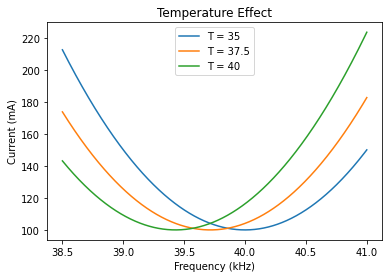

In [185]:
freqs = np.linspace(38.5,41,1000,dtype=np.float32)
USM.set_temp(35)
currents_35 = np.array(USM.USM_current(freqs))
USM.set_temp(37.5)
currents_37_5 = np.array(USM.USM_current(freqs))
USM.set_temp(40)
currents_40 = np.array(USM.USM_current(freqs))
plt.plot(freqs, currents_35, label='T = 35')
plt.plot(freqs, currents_37_5, label='T = 37.5')
plt.plot(freqs, currents_40, label='T = 40')


plt.legend(loc='best')
plt.xlabel("Frequency (kHz)");
plt.ylabel("Current (mA)");
plt.title("Temperature Effect");
plt.show()

In [186]:
# create freq scaler
scaler_freq = StandardScaler()
freqs = np.linspace(39,41,1000,dtype=np.float32).reshape(-1, 1)
scaler_freq.fit(freqs);

# create temp scaler
scaler_temp = StandardScaler()
temps = np.linspace(30,50,1000,dtype=np.float32).reshape(-1, 1)
scaler_temp.fit(temps);

scaler_reward = StandardScaler()
USM.set_temp(35)
currents = np.array(USM.USM_current(freqs))
scaler_reward.fit(currents);

In [187]:
class Agent(object):
    def __init__(self, alpha, beta, gamma=0, n_action=3, load=False,
                 input_dims=2, layer_shared=16, layer_actor=8, layer_critic=8):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.load = load
        self.input_dims = input_dims
        self.n_action = n_action
        self.layer_shared = layer_shared
        self.layer_actor = layer_actor
        self.layer_critic = layer_critic
        self.action_space = [i for i in range(n_action)]
        self.memory = deque(maxlen=1000)


        self.actor, self.critic, self.policy, self.delta = self.build_actor_critic_network()



    def build_actor_critic_network(self, load=False):

        main_input = Input(shape=(self.input_dims,), name='main_input')
        delta = tf.Variable([[0.]], trainable=False)

        dense_shared = Dense(self.layer_shared, activation='relu', name='dense_shared')(main_input)

        dense_actor = Dense(self.layer_actor, activation='relu', name='dense_actor')(dense_shared)
        output_actor = Dense(self.n_action, activation='softmax', name='output_actor')(dense_actor)

        dense_critic = Dense(self.layer_critic, activation='relu', name='dense_critic')(dense_shared)
        output_critic = Dense(1, activation='linear', name='output_critic')(dense_critic)

        def custom_loss(delta):
            def loss(y_true, y_pred):
                y_pred_clipped = K.clip(y_pred, 1e-8, 1 - 1e-8)
                log_likelihood = y_true * K.log(y_pred_clipped)
                return K.sum(-log_likelihood * delta)
            return loss

        model_actor = Model(inputs=[main_input], outputs=output_actor, name='model_actor')
        model_actor.compile(optimizer=Adam(lr=self.alpha), loss=custom_loss(delta))

        model_critic = Model(inputs=[main_input], outputs=output_critic, name='model_critic')
        model_critic.compile(optimizer=Adam(lr=self.beta), loss='mean_squared_error')

        model_policy = Model(inputs=[main_input], outputs=output_actor)
        #model_critic.layers[1].trainable = False
        #print(f'layer "{model_critic.layers[1].name}" of the "model_critic" frozen')

        return model_actor, model_critic, model_policy, delta

    def choose_action(self, state):
        state = state[np.newaxis,:]
        probabilities = self.policy.predict(state)[0]
        action = np.random.choice(self.action_space, p=probabilities)
        return action
    
    def remember(self, state, action, reward, new_state):
        self.memory.append([state, action, reward, new_state])

    def learn(self):
        batch_size = 2
        if len(self.memory) < batch_size: 
            return

        samples = random.sample(self.memory, batch_size)
        for sample in samples:
            state, action, reward, state_ = sample

            state = state[np.newaxis,:]
            state_ = state_[np.newaxis,:]

            critic_value_ = self.critic.predict(state_)
            critic_value = self.critic.predict(state)

            target = reward + self.gamma * critic_value_
            delta_numpy = target - critic_value

            actions = np.zeros([1, self.n_action])
            actions[np.arange(1), action] = 1.0

            self.delta.assign(delta_numpy)
            self.actor.fit(state, actions, verbose=0)
            self.critic.fit(state, target, verbose=0)

In [188]:
agent = Agent(alpha=0.01, beta=0.05)

train_actions = []
train_states = []
train_rewards = []
train_steps = []
train_temps = []
num_episodes = 20
ep_steps = 250
for i in range(num_episodes):
  USM.set_freq(41)#38+round(random.random(),1)*4
  USM.set_temp(35+i%5)
  observation_freq = USM.get_freq()
  observation_freq = scaler_freq.transform(np.array(observation_freq).reshape(-1,1))
  observation_temp = USM.get_temp()
  observation_temp = scaler_temp.transform(np.array(observation_temp).reshape(-1,1))
  observation = np.array([observation_freq,observation_temp]).squeeze()
  mean_reward = 0
  sign = 1
  for step in range(ep_steps):
    action = agent.choose_action(observation)
    observation_freq_, reward = USM.step(action)
    
    #observation_temp_ = USM.get_temp()

    #if observation_temp_ > 40:
      #sign = -1
    #USM.step_temp(sign*5/750)

    train_steps.append(step)
    train_rewards.append(reward)
    train_actions.append(action)
    train_states.append(observation_freq_)
    train_temps.append(observation_temp_)


    observation_freq_ = scaler_freq.transform(np.array(observation_freq_).reshape(-1,1))
    observation_temp_ = scaler_temp.transform(np.array(observation_temp_).reshape(-1,1))

    observation_ = np.array([observation_freq_,observation_temp_]).squeeze()

    

    mean_reward = mean_reward + (reward-mean_reward)/(step+1)  

    reward = scaler_reward.transform(np.array(reward).reshape(-1,1))
    #agent.learn(observation, action, -reward, observation_)

    agent.remember(observation, action, -reward, observation_)
      
    agent.learn()       # internally iterates default (prediction) model

    observation = observation_


    if (step % 50) == 0:
      print("Step: {} -- freq: {} -- reward: {}".format(step,USM.get_freq(),mean_reward))



Step: 0 -- freq: 41 -- reward: 150.0
Step: 50 -- freq: 41.179999999999964 -- reward: 163.03254901960509
Step: 100 -- freq: 41.44999999999991 -- reward: 175.49386138613286
Step: 150 -- freq: 41.58999999999988 -- reward: 190.92499999999038
Step: 200 -- freq: 42.04999999999979 -- reward: 209.1357213930203
Step: 0 -- freq: 41 -- reward: 162.08163265306118
Step: 50 -- freq: 40.95000000000001 -- reward: 160.39547018807554
Step: 100 -- freq: 40.920000000000016 -- reward: 157.89755203071405
Step: 150 -- freq: 40.76000000000005 -- reward: 154.2977726719841
Step: 200 -- freq: 40.69000000000006 -- reward: 149.74803634887016
Step: 0 -- freq: 40.99 -- reward: 174.24581632653076
Step: 50 -- freq: 40.81000000000004 -- reward: 166.0536174469805
Step: 100 -- freq: 40.59000000000008 -- reward: 154.06931703374778
Step: 150 -- freq: 40.420000000000115 -- reward: 145.6885741316441
Step: 200 -- freq: 40.25000000000015 -- reward: 138.144053711042
Step: 0 -- freq: 41 -- reward: 190.1632653061223
Step: 50 -- f

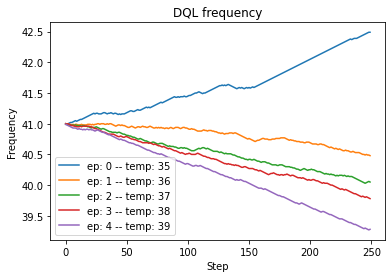

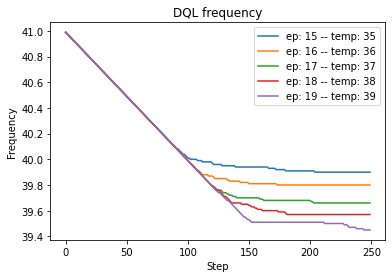

In [228]:
all_temps = list(range(35,40))
states = np.array(train_states).reshape([20,-1])
steps = np.array(train_steps).reshape([20,-1])
for i in list(range(5)):
  plt.plot(steps[i], states[i], label='ep: {} -- temp: {}'.format(i,all_temps[i%5]))
  plt.xlabel("Step");
  plt.ylabel("Frequency");
  plt.title("DQL frequency");
plt.legend(loc='best')
plt.show()

for i in list(range(15,20)):
  plt.plot(steps[i], states[i], label='ep: {} -- temp: {}'.format(i,all_temps[i%5]))
  plt.xlabel("Step");
  plt.ylabel("Frequency");
  plt.title("DQL frequency");
plt.legend(loc='best')
plt.show()

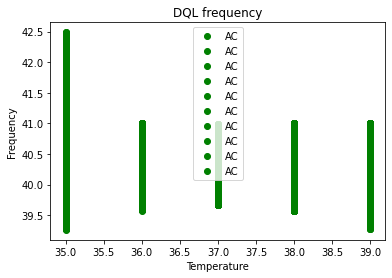

In [211]:
states = np.array(train_states).reshape([10,-1])
temps = np.array(train_temps).reshape([10,-1])

opt_freqs = np.multiply(opt_freq, (1-0.1*(temps-min_temp)/min_temp))
for i in range(10):
  plt.plot(temps[i], states[i], 'go', label='AC')
  #plt.plot(temps, opt_freqs, 'r--', label='Optimum')

  plt.xlabel("Temperature");
  plt.ylabel("Frequency");
  plt.title("DQL frequency");
plt.legend(loc='best')
plt.show()

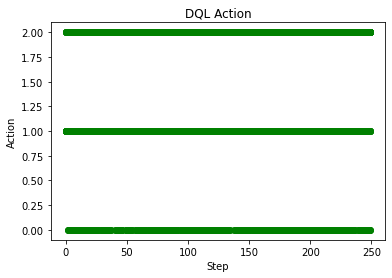

In [191]:
actions = np.array(train_actions).squeeze()
plt.plot(train_steps, actions, 'go', label='True data')
plt.xlabel("Step");
plt.ylabel("Action");
plt.title("DQL Action");
plt.show()

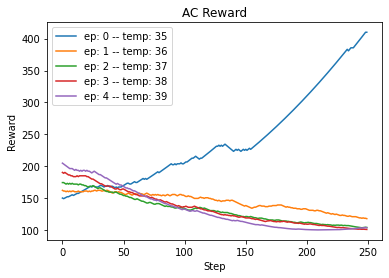

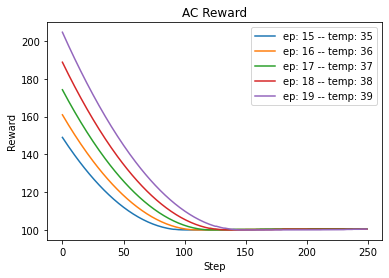

In [229]:
rewards = np.array(train_rewards).reshape([20,-1])
for i in list(range(5)):
  plt.plot(steps[i], rewards[i], label='ep: {} -- temp: {}'.format(i,all_temps[i%5]))
  plt.xlabel("Step");
  plt.ylabel("Reward");
  plt.title("AC Reward");
plt.legend(loc='best')
plt.show()

for i in list(range(15,20)):
  plt.plot(steps[i], rewards[i], label='ep: {} -- temp: {}'.format(i,all_temps[i%5]))
  plt.xlabel("Step");
  plt.ylabel("Reward");
  plt.title("AC Reward");
plt.legend(loc='best')
plt.show()

In [193]:
USM.set_freq(41)#38+round(random.random(),1)*4
USM.set_temp(40)
observation_freq = USM.get_freq()
observation_freq = scaler_freq.transform(np.array(observation_freq).reshape(-1,1))
observation_temp = USM.get_temp()
observation_temp = scaler_temp.transform(np.array(observation_temp).reshape(-1,1))
observation = np.array([observation_freq,observation_temp]).squeeze()
actions = []
states = []
rewards = []
steps = []
for i in range (1000):
  action = agent.choose_action(observation)
  # Advance the game to the next frame based on the action.
  # Reward is 1 for every frame the pole survived
  next_freq, reward = USM.step(action)
  states.append(next_freq)
  observation_freq = scaler_freq.transform(np.array(next_freq).reshape(-1,1))
  observation = np.array([observation_freq,observation_temp]).squeeze()
  steps.append(i)
  rewards.append(reward)
  actions.append(action)


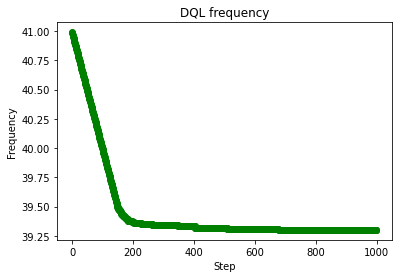

In [194]:
states_40 = np.array(states).squeeze()
plt.plot(steps, states_40, 'go', label='True data')
plt.xlabel("Step");
plt.ylabel("Frequency");
plt.title("DQL frequency");
plt.show()

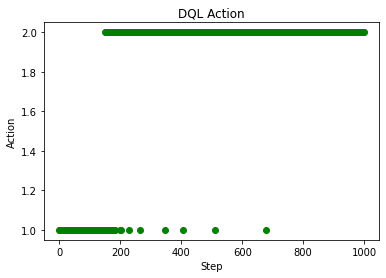

In [195]:
actions_40 = np.array(actions).squeeze()
plt.plot(steps, actions_40, 'go', label='True data')
plt.xlabel("Step");
plt.ylabel("Action");
plt.title("DQL Action");
plt.show()

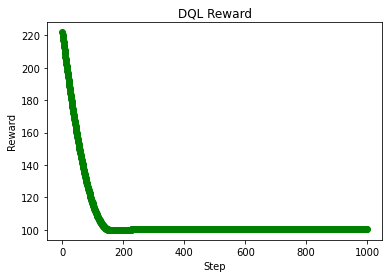

In [196]:
rewards_40 = np.array(rewards).squeeze()
plt.plot(steps, rewards_40, 'go', label='True data')
plt.xlabel("Step");
plt.ylabel("Reward");
plt.title("DQL Reward");
plt.show()

In [197]:
USM.set_freq(41)#38+round(random.random(),1)*4
USM.set_temp(35)
observation_freq = USM.get_freq()
observation_freq = scaler_freq.transform(np.array(observation_freq).reshape(-1,1))
observation_temp = USM.get_temp()
observation_temp = scaler_temp.transform(np.array(observation_temp).reshape(-1,1))
observation = np.array([observation_freq,observation_temp]).squeeze()
actions = []
states = []
rewards = []
steps = []
for i in range (1000):
  action = agent.choose_action(observation)
  # Advance the game to the next frame based on the action.
  # Reward is 1 for every frame the pole survived
  next_freq, reward = USM.step(action)
  states.append(next_freq)
  observation_freq = scaler_freq.transform(np.array(next_freq).reshape(-1,1))
  observation = np.array([observation_freq,observation_temp]).squeeze()
  steps.append(i)
  rewards.append(reward)
  actions.append(action)


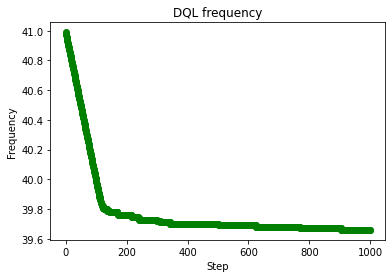

In [198]:
states_35 = np.array(states).squeeze()
plt.plot(steps, states_35, 'go', label='True data')
plt.xlabel("Step");
plt.ylabel("Frequency");
plt.title("DQL frequency");
plt.show()

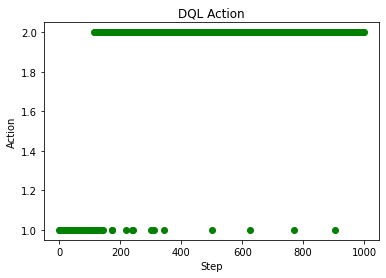

In [199]:
actions_35 = np.array(actions).squeeze()
plt.plot(steps, actions_35, 'go', label='True data')
plt.xlabel("Step");
plt.ylabel("Action");
plt.title("DQL Action");
plt.show()

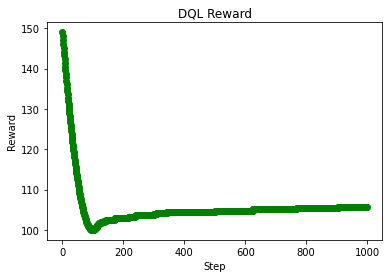

In [200]:
rewards_35 = np.array(rewards).squeeze()
plt.plot(steps, rewards_35, 'go', label='True data')
plt.xlabel("Step");
plt.ylabel("Reward");
plt.title("DQL Reward");
plt.show()

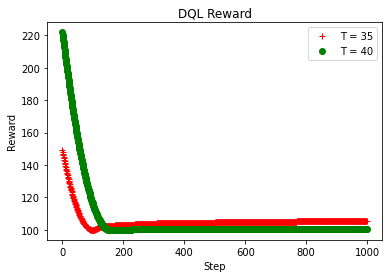

In [201]:
plt.plot(stps, rewards_35, 'r+', label='T = 35')
plt.plot(steps, rewards_40, 'go', label='T = 40')

plt.xlabel("Step");
plt.ylabel("Reward");
plt.title("DQL Reward");
plt.legend(loc='best');
plt.show()

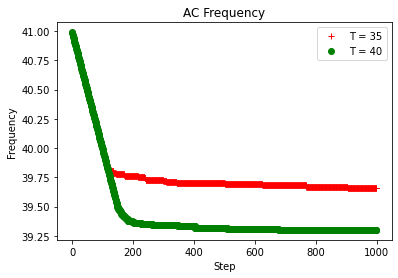

In [231]:
plt.plot(states_35, 'r+', label='T = 35')
plt.plot(states_40, 'go', label='T = 40')

plt.xlabel("Step");
plt.ylabel("Frequency");
plt.title("AC Frequency");
plt.legend(loc='best');
plt.show()